In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pyrotd
import glob

In [2]:
files = glob.glob("PEERNGARecords_Unscaled_S2/*.AT*")

In [3]:
"""import sys
sys.path.append('./REQPY-master/')
from REQPY_Module import REQPY_single, load_PEERNGA_record"""

"import sys\nsys.path.append('./REQPY-master/')\nfrom REQPY_Module import REQPY_single, load_PEERNGA_record"

In [4]:
ground_motions = {}
for fname in files:
    eq_id = fname.split('\\')[-1].split('_')[0]
    if not(eq_id in ground_motions.keys()):
        ground_motions[eq_id] = {'Name':None, 'Date':None, 'Station':None, 'time_step':None, 'Comp':{}}
    with open(fname) as fp:
        next(fp)
        meta01 = next(fp).strip().split(',')
        ground_motions[eq_id]['Name'] = meta01[0].strip()
        ground_motions[eq_id]['Date'] = meta01[1].strip()
        ground_motions[eq_id]['Station'] = meta01[2].strip()
        next(fp)
        ground_motions[eq_id]['time_step'] = float(next(fp)[17:25])
        ground_motions[eq_id]['Comp'][meta01[3]] = np.array([p for l in fp for p in l.split()]).astype(float)

In [5]:
for eqid, data in ground_motions.items():
    for cmp in [' UP',' VRT',' UD',' DWN',' V',' UD']:
        if cmp in data['Comp'].keys():
            del ground_motions[eqid]['Comp'][cmp]

In [6]:
ground_motions.keys()

dict_keys(['RSN1083', 'RSN1614', 'RSN1616', 'RSN1633', 'RSN164', 'RSN286', 'RSN289', 'RSN290', 'RSN313', 'RSN3750', 'RSN3753', 'RSN3757', 'RSN3759', 'RSN3907', 'RSN3926', 'RSN3927', 'RSN3932', 'RSN3948', 'RSN4013', 'RSN4841', 'RSN4843', 'RSN57', 'RSN70', 'RSN740', 'RSN755', 'RSN78', 'RSN827', 'RSN830', 'RSN864', 'RSN881', 'RSN88'])

In [7]:
def read_peer_record(file):
    with open(file) as f:
        f.readline()
        f.readline()
        f.readline()
        dt = np.float(f.readline().split(',')[1].split('=')[1][:9])
        data = []
        for line in f:
            for val in line.strip().split():
                data.append(float(val))
        return dt , np.array(data)

In [8]:
template = open('AbaqusRun2/template.inp','r').readlines()
template_str = ''
for line in template:
    template_str = template_str + line

In [9]:
xdir = np.loadtxt('GenTH/xdir_20sec.acc')[1:]
ydir = np.loadtxt('GenTH/ydir_20sec.acc')[1:]

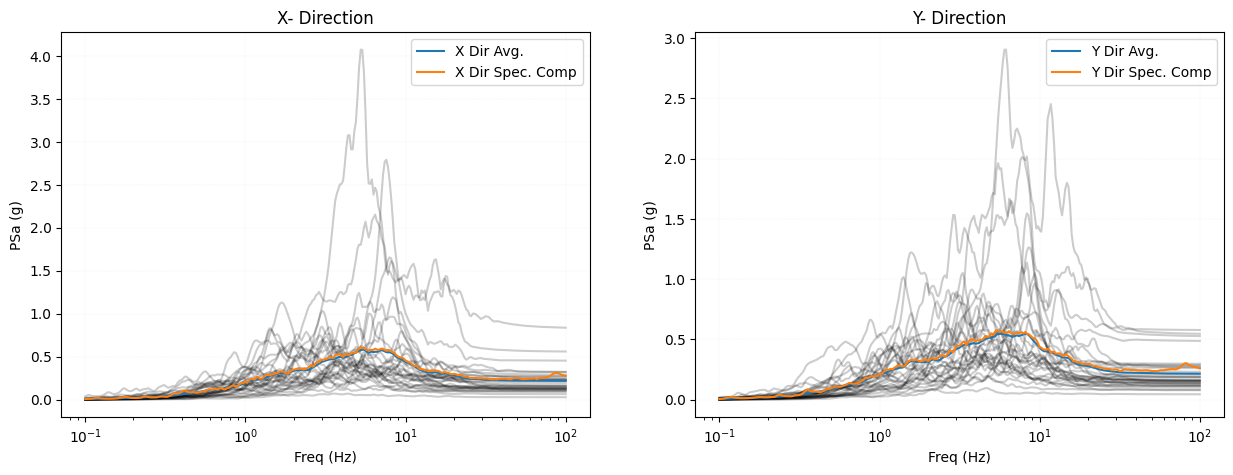

In [12]:
eq_list = ['RSN164','RSN4013','RSN4841','RSN4843','RSN57','RSN70','RSN830','RSN88']
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,5))
freq = 10**(np.linspace(-1,2, 301))
xdir_avg = np.zeros(301)
ydir_avg = np.zeros(301)
for eqid, data in ground_motions.items():
    th_key = list(ground_motions[eqid]['Comp'].keys())
    resp_spec_x = pyrotd.calc_spec_accels(ground_motions[eqid]['time_step'], ground_motions[eqid]['Comp'][th_key[0]],\
                                          freq, osc_damping=0.05, max_freq_ratio=5, osc_type='psa')
    resp_spec_y = pyrotd.calc_spec_accels(ground_motions[eqid]['time_step'], ground_motions[eqid]['Comp'][th_key[1]],\
                                          freq, osc_damping=0.05, max_freq_ratio=5, osc_type='psa')
    xdir_avg = xdir_avg + resp_spec_x['spec_accel']/len(ground_motions)
    ydir_avg = ydir_avg + resp_spec_y['spec_accel']/len(ground_motions)
    ax[0].semilogx(freq, resp_spec_x['spec_accel'], c='k', alpha=0.2)
    ax[1].semilogx(freq, resp_spec_y['spec_accel'], c='k', alpha=0.2)
ax[0].semilogx(freq, xdir_avg, label='X Dir Avg.')
ax[1].semilogx(freq, ydir_avg, label='Y Dir Avg.')
resp_spec_cx = pyrotd.calc_spec_accels(0.005, xdir,\
                                          freq, osc_damping=0.05, max_freq_ratio=5, osc_type='psa')
resp_spec_cy = pyrotd.calc_spec_accels(0.005, ydir,\
                                          freq, osc_damping=0.05, max_freq_ratio=5, osc_type='psa')
ax[0].semilogx(freq, resp_spec_cx['spec_accel'], label='X Dir Spec. Comp')
ax[1].semilogx(freq, resp_spec_cy['spec_accel'], label='Y Dir Spec. Comp')
ax[0].legend()
ax[1].legend()

ax[0].set_xlabel('Freq (Hz)')
ax[1].set_xlabel('Freq (Hz)')
ax[0].set_ylabel('PSa (g)')
ax[1].set_ylabel('PSa (g)')

ax[0].set_title('X- Direction')
ax[1].set_title('Y- Direction')

ax[0].grid(color='k', linestyle='--', linewidth=0.1, alpha=0.2)
ax[1].grid(color='k', linestyle='--', linewidth=0.1, alpha=0.2)

plt.savefig('ResponseSpectra.png')

In [13]:
"""JobName = '{0:s}_{1:s}.inp'.format(eqid,data['Name'].strip())
inp_fname = 'AbaqusRun2/{0:s}_{1:s}.inp'.format('SpecComp17secX','SpecComp17secY')
coda_duration = 10 #second
with open(inp_fname,'w') as f:
    th_str1 = ''
    for j,dd in enumerate(xdir):
        if (j%4 == 0):
            th_str1 = th_str1 + '\n{0:15.8f},{1:15.8f}'.format(j*0.005,dd)
        else:
            th_str1 = th_str1 + ',{0:15.8f},{1:15.8f}'.format(j*0.005,dd)
    th_str2 = ''
    for j,dd in enumerate(ydir):
        if (j%4 == 0):
            th_str2 = th_str2 + '\n{0:15.8f},{1:15.8f}'.format(j*0.005,dd)
        else:
            th_str2 = th_str2 + ',{0:15.8f},{1:15.8f}'.format(j*0.005,dd)
    DT = 0.005
    DUR = j*0.005
    f.write(template_str.format('X_DIR',th_str1[1:-1],\
            'Y_DIR',th_str2[1:-1],\
            DT,DUR+coda_duration,JobName[:-4]))"""

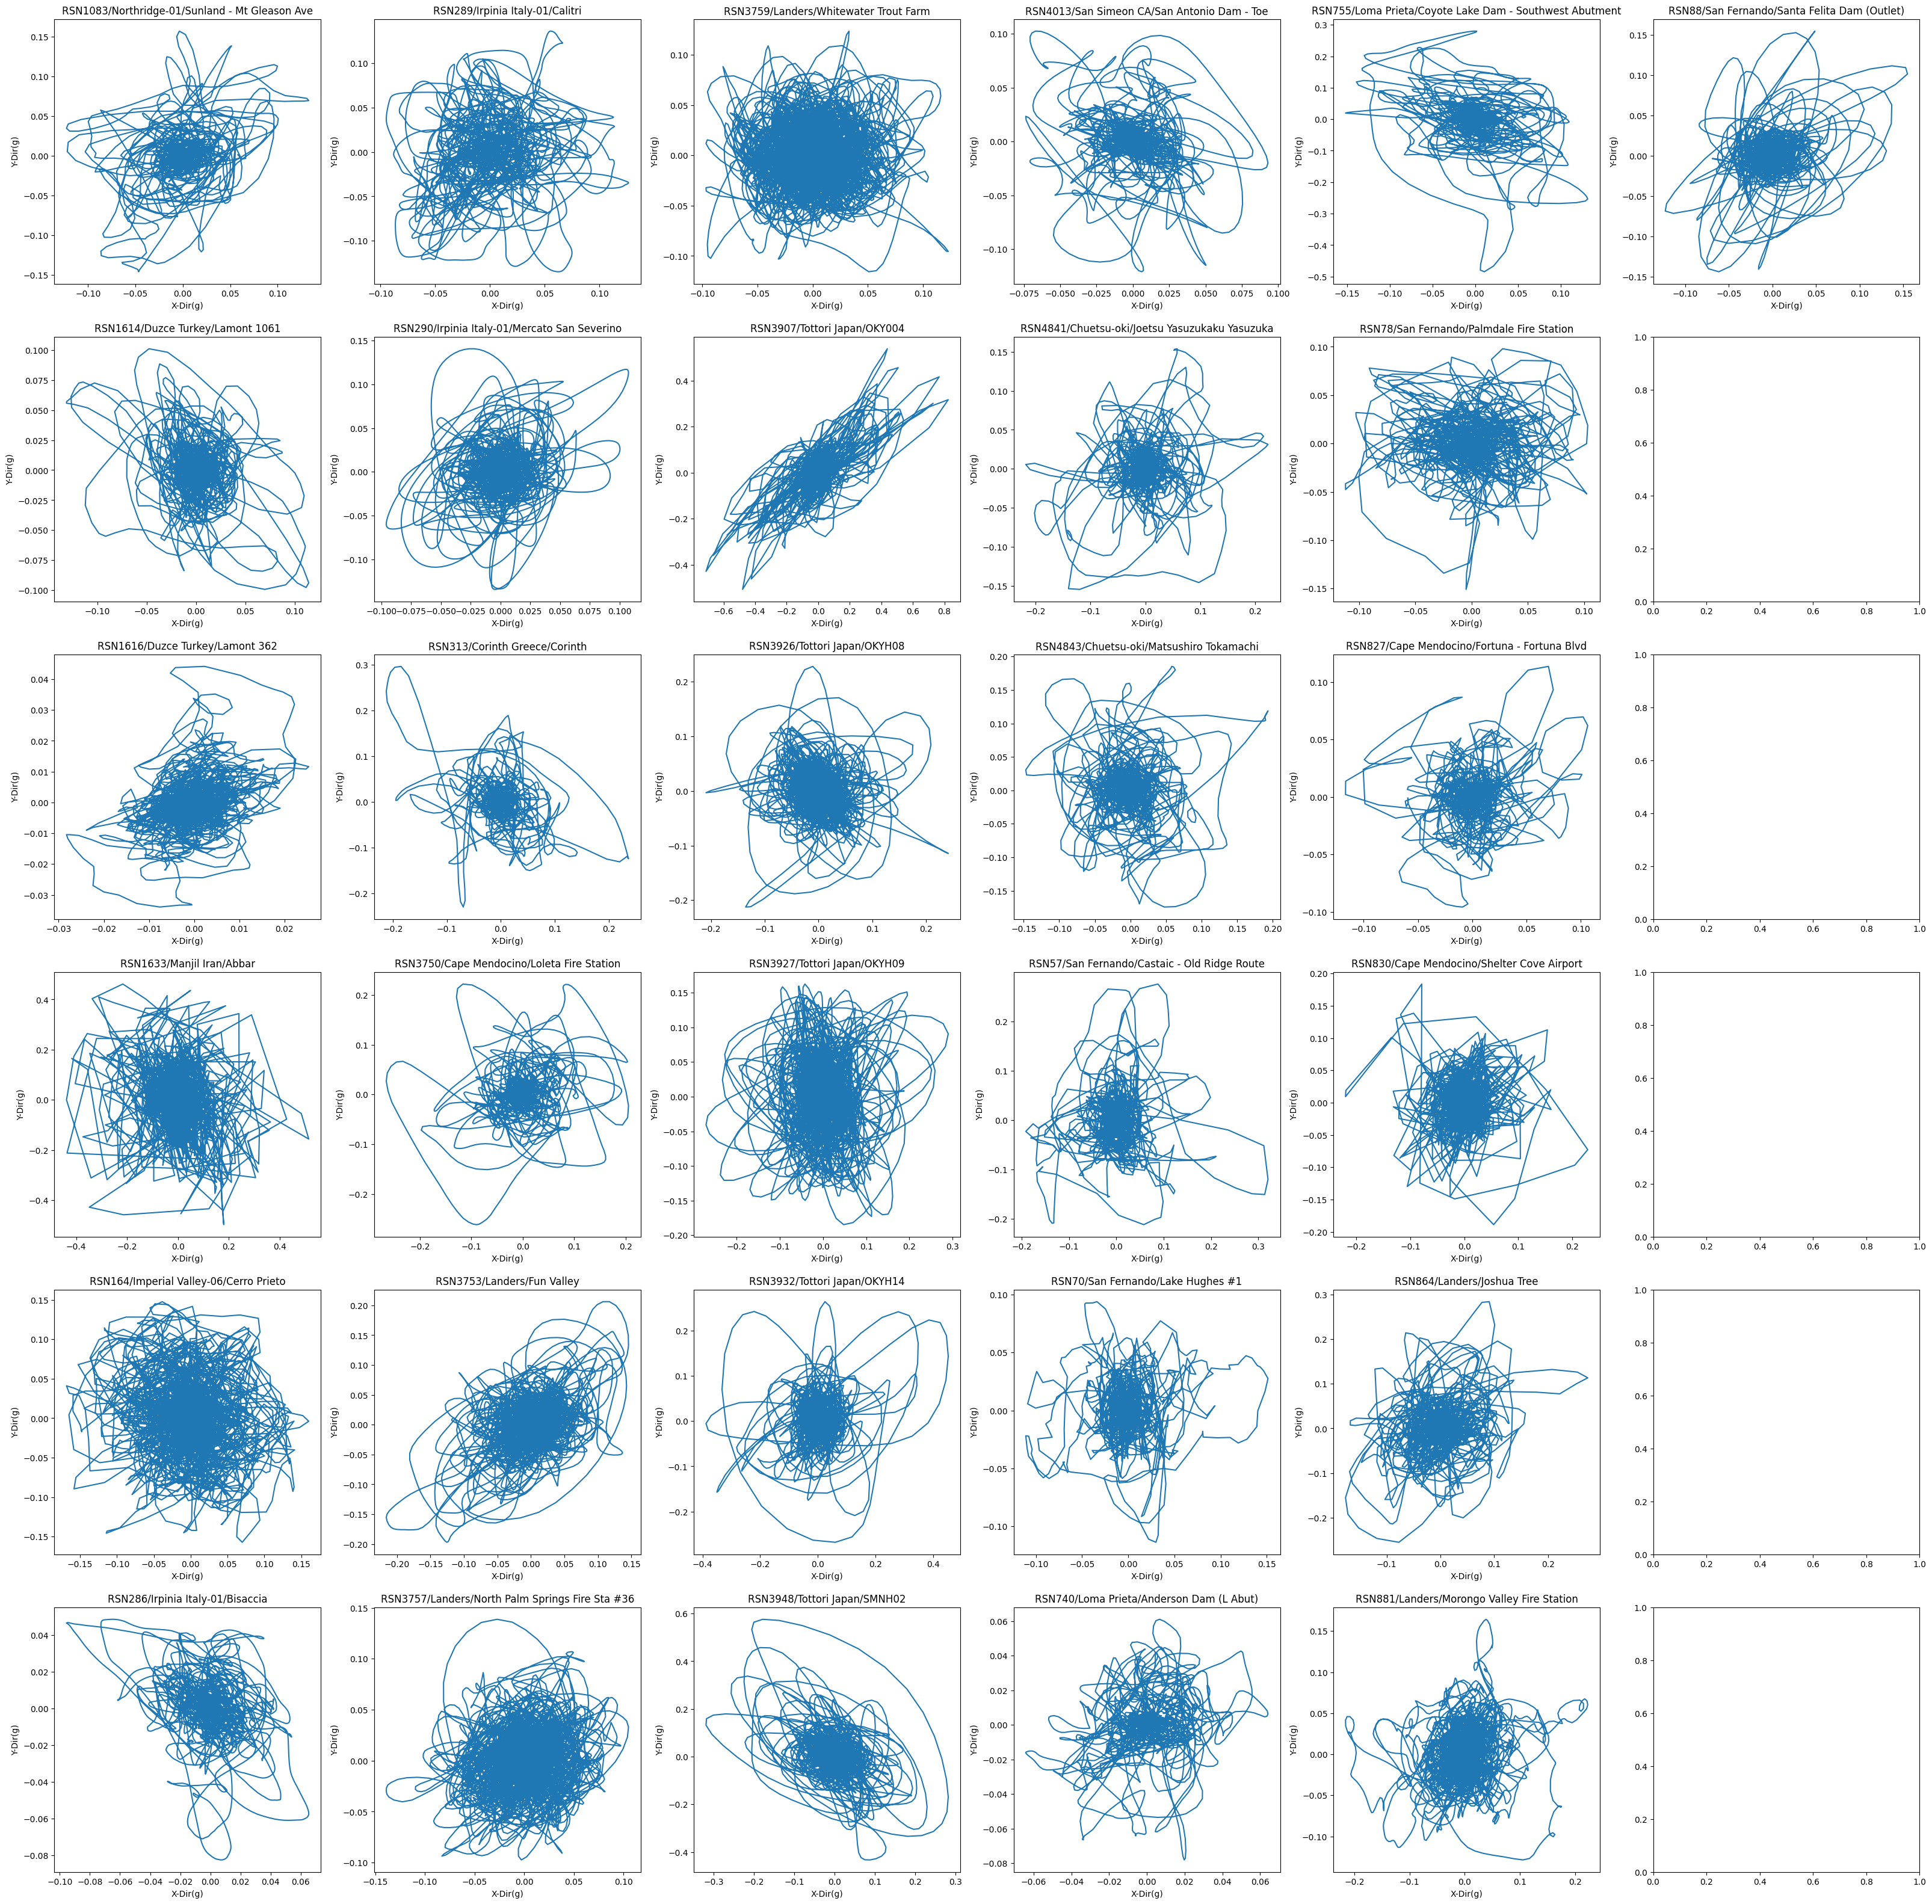

In [62]:
fig, ax = plt.subplots(nrows=6, ncols=6, figsize=(40,40))
i = 0
for eqid, data in ground_motions.items():
    vv = list(data['Comp'].keys())
    ff = min(len(data['Comp'][vv[0]]),len(data['Comp'][vv[1]]))
    ax[i%6,int(np.floor(i/6))].plot(data['Comp'][vv[0]][:ff],data['Comp'][vv[1]][:ff])
    ax[i%6,int(np.floor(i/6))].set_xlabel('X-Dir(g)')
    ax[i%6,int(np.floor(i/6))].set_ylabel('Y-Dir(g)')
    ax[i%6,int(np.floor(i/6))].set_title(eqid + '/' + data['Name'] + '/' + data['Station'])
    i = i + 1
plt.savefig('Annexure02.pdf')

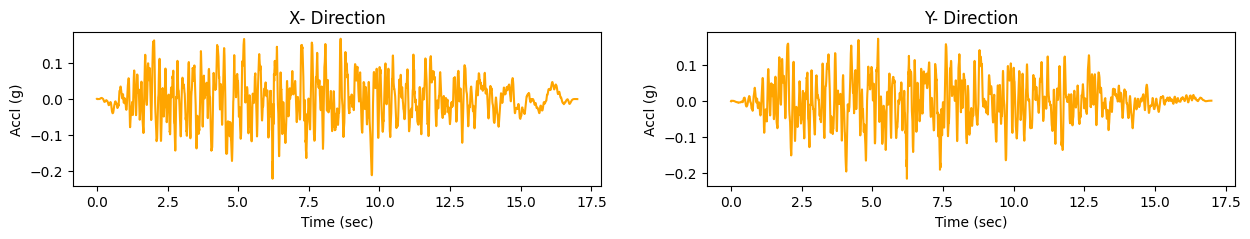

In [44]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,2))
ax[0].plot(np.arange(len(xdir))*0.005,xdir,c='orange')
ax[1].plot(np.arange(len(xdir))*0.005,ydir,c='orange')
ax[0].set_xlabel('Time (sec)')
ax[1].set_xlabel('Time (sec)')
ax[0].set_ylabel('Accl (g)')
ax[1].set_ylabel('Accl (g)')
ax[0].set_title('X- Direction')
ax[1].set_title('Y- Direction')
plt.savefig('spec_comp.png')

In [52]:
sttt = ''
for eqid, data in ground_motions.items():
    vv = list(data['Comp'].keys())
    sttt = sttt + '{0:s},{1:s},{2:s},{3:s},{4:7.3f},{5:7.3f}\n'.format(eqid,\
            data['Name'], data['Station'], data['Date'], max(data['Comp'][vv[0]]), max(data['Comp'][vv[1]]))


In [55]:
print(sttt)

RSN1083,Northridge-01,Sunland - Mt Gleason Ave,1/17/1994,  0.133,  0.157
RSN1614,Duzce Turkey,Lamont 1061,11/12/1999,  0.114,  0.101
RSN1616,Duzce Turkey,Lamont 362,11/12/1999,  0.025,  0.044
RSN1633,Manjil Iran,Abbar,6/20/1990,  0.515,  0.462
RSN164,Imperial Valley-06,Cerro Prieto,10/15/1979,  0.160,  0.148
RSN286,Irpinia Italy-01,Bisaccia,11/23/1980,  0.065,  0.049
RSN289,Irpinia Italy-01,Calitri,11/23/1980,  0.126,  0.136
RSN290,Irpinia Italy-01,Mercato San Severino,11/23/1980,  0.108,  0.140
RSN313,Corinth Greece,Corinth,2/24/1981,  0.237,  0.296
RSN3750,Cape Mendocino,Loleta Fire Station,4/25/1992,  0.205,  0.222
RSN3753,Landers,Fun Valley,6/28/1992,  0.146,  0.206
RSN3757,Landers,North Palm Springs Fire Sta #36,6/28/1992,  0.105,  0.139
RSN3759,Landers,Whitewater Trout Farm,6/28/1992,  0.123,  0.124
RSN3907,Tottori Japan,OKY004,10/6/2000,  0.825,  0.539
RSN3926,Tottori Japan,OKYH08,10/6/2000,  0.241,  0.228
RSN3927,Tottori Japan,OKYH09,10/6/2000,  0.290,  0.163
RSN3932,Tottori Ja

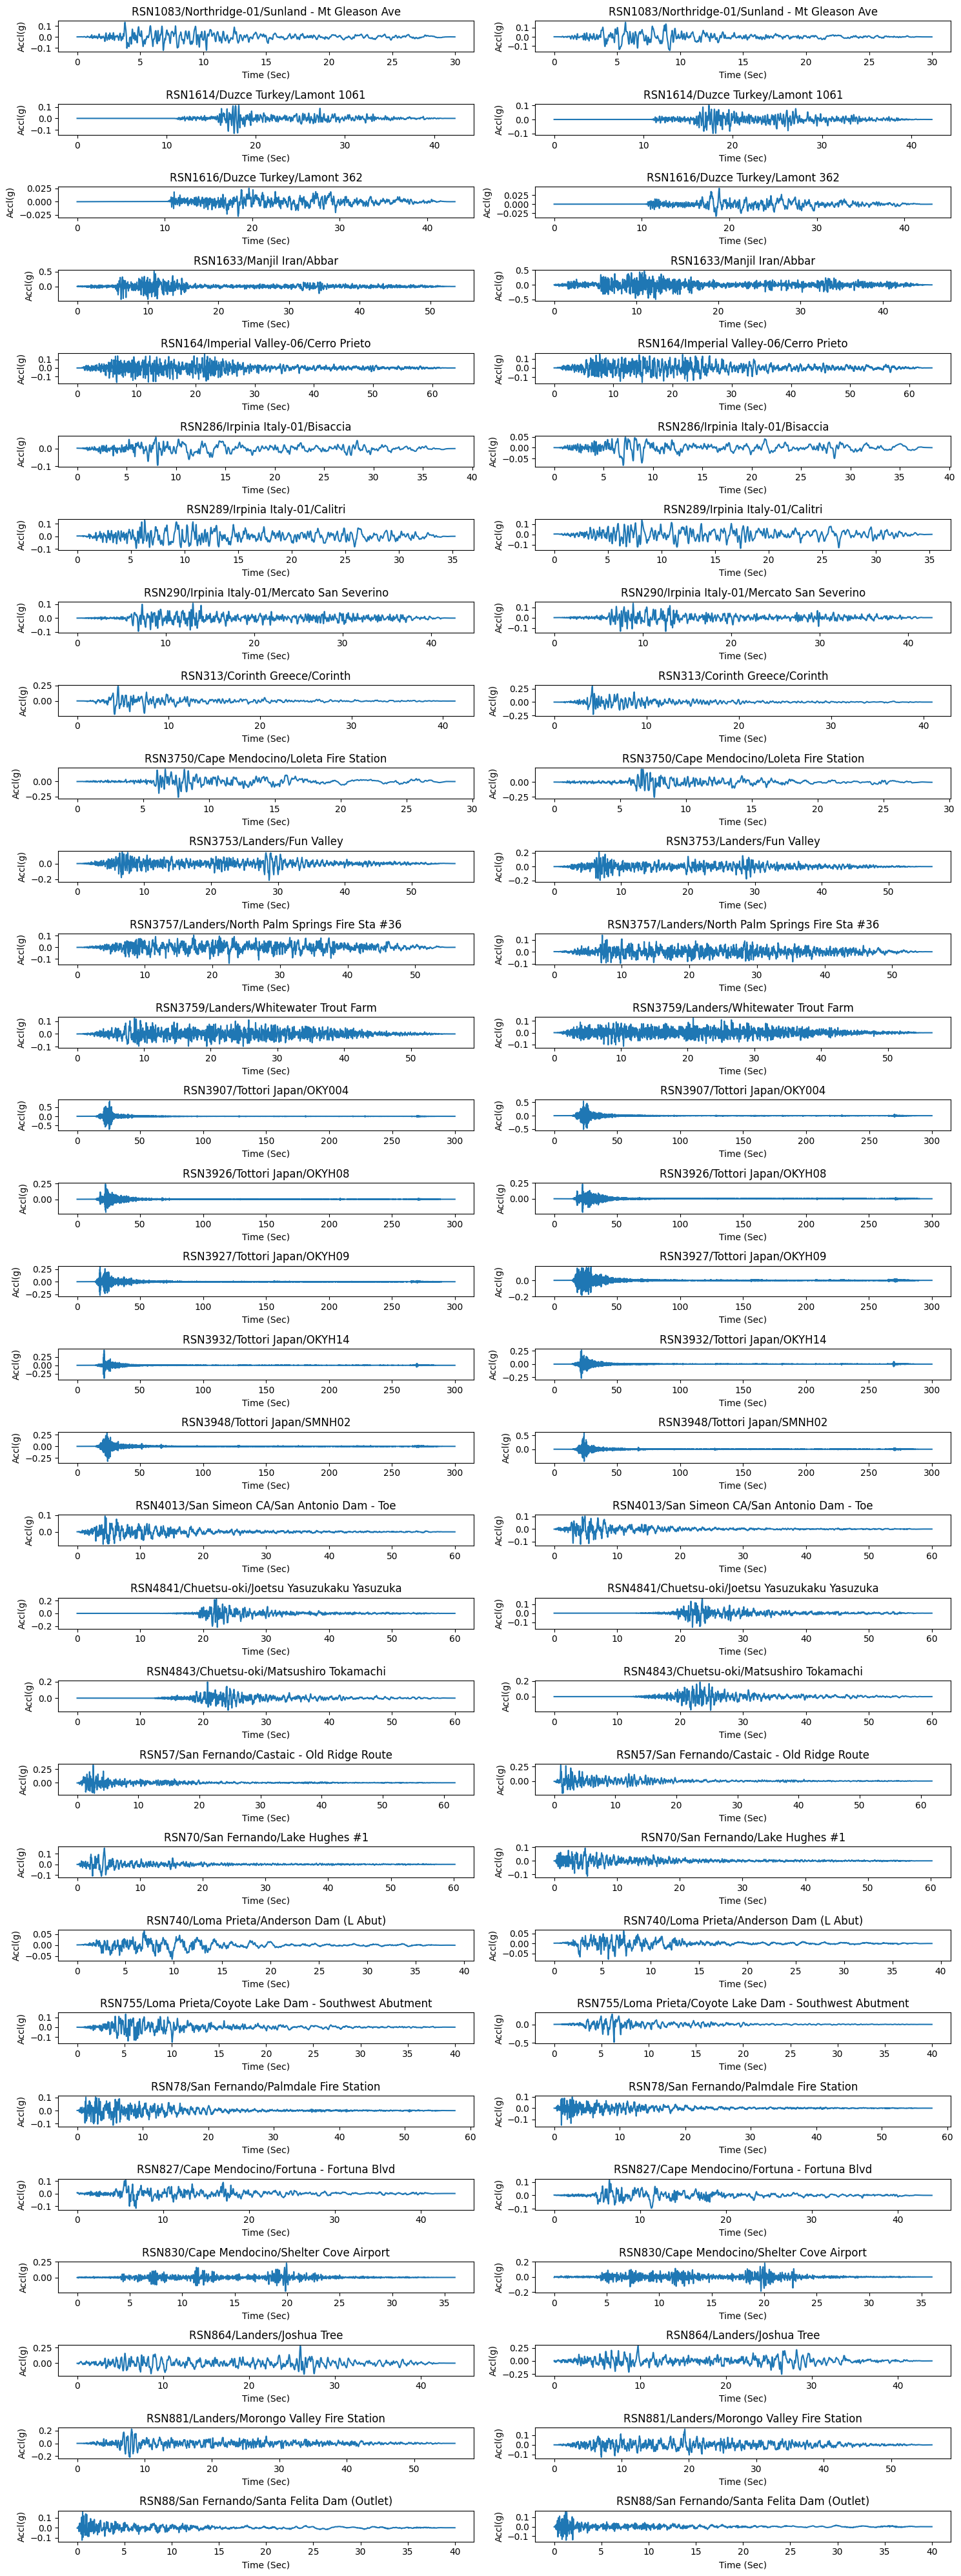

In [60]:
fig, ax = plt.subplots(nrows=31, ncols=2, figsize=(15,40))
i = 0
for eqid, data in ground_motions.items():
    vv = list(data['Comp'].keys())
    ax[i,0].plot(data['time_step']*np.arange(len(data['Comp'][vv[0]])), data['Comp'][vv[0]])
    ax[i,1].plot(data['time_step']*np.arange(len(data['Comp'][vv[1]])), data['Comp'][vv[1]])
    ax[i,0].set_xlabel('Time (Sec)')
    ax[i,0].set_ylabel('Accl(g)')
    ax[i,0].set_title(eqid + '/' + data['Name'] + '/' + data['Station'])
    ax[i,1].set_xlabel('Time (Sec)')
    ax[i,1].set_ylabel('Accl(g)')
    ax[i,1].set_title(eqid + '/' + data['Name'] + '/' + data['Station'])
    i = i + 1
plt.tight_layout()
plt.savefig('Annexure01.pdf')

In [57]:
data['Comp'][vv[0]]

array([3.227446e-04, 3.222617e-04, 3.215598e-04, ..., 1.170422e-04,
       1.055751e-04, 9.411206e-05])